# Homework 2

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Aman Krishna
* amank@uchicago.edu

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology` and
- the market data file `market_prices_eod`.


# Problem 1: Constructing fixed rate bonds

In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import random

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

mydir = os.getcwd()

c:\Users\Aman\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Aman\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Aman\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Aman\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Calculate initial term and current time-to-maturity for each bond issue
def get_symbology(df, underlying=False):
    for index, row in df.iterrows():
        start_date = ql.Date(row['start_date'].day, row['start_date'].month, row['start_date'].year)
        maturity_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        today_date = ql.Date(14,4,2023)
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        #set dcc as Actual/365.25
        dcc = ql.Actual36525()
        initial_term = dcc.yearFraction(start_date, maturity_date)
        current_time_to_maturity = dcc.yearFraction(today_date, maturity_date)
        df.at[index, 'term'] = initial_term
        df.at[index, 'TTM'] = current_time_to_maturity

    if underlying:
        return df[['ticker','figi','security','name','und_bench_isin','coupon','days_settle','start_date','acc_first', 'maturity', 'term', 'TTM']]
    else:
        #round term to integer
        df['term'] = round(df['term'],2)
        df1 = df[['ticker','figi','security','name','coupon','days_settle','start_date','acc_first', 'maturity', 'term', 'TTM']]
        return df1

## a. Prepare common symbology dataframe for fixed rate government and corporate bonds

Load the `govt_symbology` and `corp_symbology` Excel files into one common dataframe, using the `corp_symbology` columns. Filter the dataframe and keep fixed rate bonds only: (cpn_type="FIXED").


In [3]:
govt_symbology = pd.read_excel(os.path.join(mydir, 'data', 'govt_symbology.xlsx'))
#keep only cpn_type="FIXED" bonds
govt_symbology = govt_symbology[govt_symbology['cpn_type'] == 'FIXED']
#reset index
govt_symbology = govt_symbology.reset_index(drop=True)
govt_symbology.head(2)

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,dcc,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,country,currency
0,T,Govt,BBG000DLJF04,US912810EQ77,TSRYS4493810,T 6 1/4 08/15/23,US TREASURY N/B,US GOVERNMENT,6.25,FIXED,ACT/ACT,2.0,1,1993-08-16,1994-02-15,1993-08-15,2023-08-15,US,USD
1,T,Govt,BBG000DKZWK9,US912810ES34,TSRYS4493811,T 7 1/2 11/15/24,US TREASURY N/B,US GOVERNMENT,7.50,FIXED,ACT/ACT,2.0,1,1994-08-15,1994-11-15,1994-05-15,2024-11-15,US,USD


In [4]:
gov_sym = get_symbology(govt_symbology)
gov_sym

,ticker,figi,security,name,coupon,days_settle,start_date,acc_first,maturity,term,TTM
0,T,BBG000DLJF04,T 6 1/4 08/15/23,US TREASURY N/B,6.250,1,1993-08-16,1993-08-15,2023-08-15,30.00,0.336756
1,T,BBG000DKZWK9,T 7 1/2 11/15/24,US TREASURY N/B,7.500,1,1994-08-15,1994-05-15,2024-11-15,30.25,1.590691
2,T,BBG000DLBVY0,T 7 5/8 02/15/25,US TREASURY N/B,7.625,1,1995-02-15,1995-02-15,2025-02-15,30.00,1.842574
3,T,BBG000DQQNJ8,T 6 7/8 08/15/25,US TREASURY N/B,6.875,1,1995-08-15,1995-08-15,2025-08-15,30.00,2.338125
4,T,BBG000DPXMD0,T 6 02/15/26,US TREASURY N/B,6.000,1,1996-02-15,1996-02-15,2026-02-15,30.00,2.841889
...,...,...,...,...,...,...,...,...,...,...,...
327,T,BBG01FQJ5MY4,T 4 5/8 03/15/26,US TREASURY N/B,4.625,1,2023-03-15,2023-03-15,2026-03-15,3.00,2.918549
328,T,BBG01G14BV75,T 3 5/8 03/31/30,US TREASURY N/B,3.625,1,2023-03-31,2023-03-31,2030-03-31,7.00,6.962355
329,T,BBG01G14BW91,T 3 5/8 03/31/28,US TREASURY N/B,3.625,1,2023-03-31,2023-03-31,2028-03-31,5.00,4.963723
330,T,BBG01G14BXX2,T 3 7/8 03/31/25,US TREASURY N/B,3.875,1,2023-03-31,2023-03-31,2025-03-31,2.00,1.963039


In [5]:
corp_symbology = pd.read_excel(os.path.join(mydir, 'data', 'corp_symbology.xlsx'))
#keep only cpn_type="FIXED" bonds
corp_symbology = corp_symbology[corp_symbology['cpn_type'] == 'FIXED']
#reset index
corp_symbology = corp_symbology.reset_index(drop=True)
corp_symbology.head(2)

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,cpn_freq,days_settle,start_date,cpn_first,acc_first,maturity,mty_typ,rank,country,currency
0,DIS,Corp,BBG00QNKJ092,US254687CZ75,DIS4921182,US91282CGU99,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,GLOBAL,3.7,...,2,2,2019-11-22,2020-03-15,2019-09-15,2024-09-15,CALLABLE,Sr Unsecured,US,USD
1,DIS,Corp,BBG00QNKPCL5,US254687DD54,DIS4907444,US91282CGU99,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,GLOBAL,3.7,...,2,2,2019-11-22,2020-04-15,2019-10-15,2025-10-15,CALLABLE,Sr Unsecured,US,USD


In [6]:
corp_sym = get_symbology(corp_symbology, underlying=True)
corp_sym

,ticker,figi,security,name,und_bench_isin,coupon,days_settle,start_date,acc_first,maturity,term,TTM
0,DIS,BBG00QNKJ092,DIS 3.7 09/15/24,WALT DISNEY COMPANY/THE,US91282CGU99,3.700,2,2019-11-22,2019-09-15,2024-09-15,4.815880,1.423682
1,DIS,BBG00QNKPCL5,DIS 3.7 10/15/25,WALT DISNEY COMPANY/THE,US91282CGU99,3.700,2,2019-11-22,2019-10-15,2025-10-15,5.897331,2.505133
2,DIS,BBG00QNKGJP6,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,US91282CGR60,3.375,2,2019-11-22,2019-11-15,2026-11-15,6.981520,3.589322
3,DIS,BBG00QNKP8R8,DIS 6.55 03/15/33,WALT DISNEY COMPANY/THE,US91282CGM73,6.550,2,2019-11-22,2019-09-15,2033-03-15,13.311431,9.919233
4,DIS,BBG00QNKR4J4,DIS 6.2 12/15/34,WALT DISNEY COMPANY/THE,US91282CGM73,6.200,2,2019-11-22,2019-06-15,2034-12-15,15.063655,11.671458
...,...,...,...,...,...,...,...,...,...,...,...,...
214,VZ,BBG017BR3G75,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,US91282CGT27,4.150,2,2022-05-19,2022-05-19,2029-05-15,6.989733,6.086242
215,VZ,BBG017QYK9Z0,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,US912810TL26,4.650,2,2022-06-03,2022-06-03,2052-06-15,30.034223,29.171800
216,VZ,BBG0191HMXJ3,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,US912810TL26,4.600,2,2022-08-11,2022-08-11,2052-08-15,30.012320,29.338809
217,VZ,BBG019LXC9P3,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,US91282CGT27,4.500,2,2022-09-22,2022-09-22,2029-09-15,6.981520,6.422998


In [7]:
#join govt and corp symbology
symbology = pd.concat([gov_sym, corp_sym], ignore_index=True)
symbology

,ticker,figi,security,name,coupon,days_settle,start_date,acc_first,maturity,term,TTM,und_bench_isin
0,T,BBG000DLJF04,T 6 1/4 08/15/23,US TREASURY N/B,6.250,1,1993-08-16,1993-08-15,2023-08-15,30.000000,0.336756,NaN
1,T,BBG000DKZWK9,T 7 1/2 11/15/24,US TREASURY N/B,7.500,1,1994-08-15,1994-05-15,2024-11-15,30.250000,1.590691,NaN
2,T,BBG000DLBVY0,T 7 5/8 02/15/25,US TREASURY N/B,7.625,1,1995-02-15,1995-02-15,2025-02-15,30.000000,1.842574,NaN
3,T,BBG000DQQNJ8,T 6 7/8 08/15/25,US TREASURY N/B,6.875,1,1995-08-15,1995-08-15,2025-08-15,30.000000,2.338125,NaN
4,T,BBG000DPXMD0,T 6 02/15/26,US TREASURY N/B,6.000,1,1996-02-15,1996-02-15,2026-02-15,30.000000,2.841889,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
546,VZ,BBG017BR3G75,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,4.150,2,2022-05-19,2022-05-19,2029-05-15,6.989733,6.086242,US91282CGT27
547,VZ,BBG017QYK9Z0,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,4.650,2,2022-06-03,2022-06-03,2052-06-15,30.034223,29.171800,US912810TL26
548,VZ,BBG0191HMXJ3,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,4.600,2,2022-08-11,2022-08-11,2052-08-15,30.012320,29.338809,US912810TL26
549,VZ,BBG019LXC9P3,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,4.500,2,2022-09-22,2022-09-22,2029-09-15,6.981520,6.422998,US91282CGT27


## b. Add function to construct generic fixed rate cashflow schedules from symbology data

Use one row of the symbology dataframe as input  to the function. Use the helper function to convert a date string to a QuantLib date object.

In [8]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

In [9]:
def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = ql.Date(details['maturity'].day, details['maturity'].month, details['maturity'].year)
    
    # Create acc_first from details['acc_first']
    acc_first = ql.Date(details['acc_first'].day, details['acc_first'].month, details['acc_first'].year)
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(ql.Semiannual)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

## c. Add function to construct generic fixed rate bond objects from symbology data

Use one row of the symbology dataframe as input to the function. Use create_schedule_from_symbology() internally to create the cashflow schedule.

In [10]:
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
     
    if details['ticker'] == 'T':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        day_count = ql.Thirty360(ql.Thirty360.USA)
    
    # Create day_count from details['start_date']    
    issue_date = ql.Date(details['start_date'].day, details['start_date'].month, details['start_date'].year)
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


## d. Add function that returns a dataframe with (future) cash flows details for a bond object

Use the "Investigate Bond Cashflows" section in the Quantlib introductory notebook as a template.

The results dataframe should contain following columns:


| CashFlowDate | CashFlowAmount | CashFlowYearFrac |
|----------|-------|-------------|

Pick one government and one corporate bond from symbology, create the bond objects and display the future cashflows.

In [11]:
def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date) -> pd.DataFrame:
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    # Create cashflows list based on calc_date and hasOccurred argument and yearFraction using bond.dayCounter()
    x = [(cf.date(), cf.amount(), bond.dayCounter().yearFraction(calc_date, cf.date())) for cf in bond.cashflows() if cf.hasOccurred() == False]
    
    cashflows_df = pd.DataFrame(x, columns=['CashFlowDate', 'CashFlowAmount', 'CashFlowYearFrac'])
    
    '''Below code can be used to merge the rows with same CashFlowDate and add CashFlowAmount'''
    # #merge the rows with same CashFlowDate and add CashFlowAmount
    # cashflows_df = cashflows_df.groupby(['CashFlowDate', 'CashFlowYearFrac']).sum().reset_index()
    
    # #rearrange columns
    # cashflows_df = cashflows_df[['CashFlowDate', 'CashFlowAmount','CashFlowYearFrac']]
    
    return cashflows_df

> We show the cashflows for the below bond

In [12]:
symbology.iloc[4]

ticker                              T
figi                     BBG000DPXMD0
security                 T 6 02/15/26
name                  US TREASURY N/B
coupon                            6.0
days_settle                         1
start_date        1996-02-15 00:00:00
acc_first         1996-02-15 00:00:00
maturity          2026-02-15 00:00:00
term                             30.0
TTM                          2.841889
und_bench_isin                    NaN
Name: 4, dtype: object

In [13]:
bond_tsy_1 = create_bond_from_symbology(symbology.iloc[4].to_dict())
get_bond_cashflows(bond_tsy_1, calc_date = ql.Date(14, 4, 2023))

,CashFlowDate,CashFlowAmount,CashFlowYearFrac
0,"August 15th, 2023",3.0,0.333333
1,"February 15th, 2024",3.0,0.833333
2,"August 15th, 2024",3.0,1.333333
3,"February 15th, 2025",3.0,1.833333
4,"August 15th, 2025",3.0,2.333333
5,"February 15th, 2026",3.0,2.833333
6,"February 15th, 2026",100.0,2.833333


>Next we pick the following corp bond from the symbology dataframe

In [14]:
symbology[symbology["ticker"]=="IBM"].iloc[0]

ticker                            IBM
figi                     BBG0000362Y4
security               IBM 7 10/30/25
name                         IBM CORP
coupon                            7.0
days_settle                         2
start_date        1995-10-30 00:00:00
acc_first         1995-10-30 00:00:00
maturity          2025-10-30 00:00:00
term                        30.001369
TTM                          2.546201
und_bench_isin           US91282CGU99
Name: 375, dtype: object

In [15]:
bond_corp_1 = create_bond_from_symbology(symbology[symbology["ticker"]=="IBM"].iloc[0].to_dict())
get_bond_cashflows(bond_corp_1, calc_date = ql.Date(14, 4, 2023))

,CashFlowDate,CashFlowAmount,CashFlowYearFrac
0,"April 30th, 2023",3.5,0.044444
1,"October 30th, 2023",3.5,0.544444
2,"April 30th, 2024",3.5,1.044444
3,"October 30th, 2024",3.5,1.544444
4,"April 30th, 2025",3.5,2.044444
5,"October 30th, 2025",3.5,2.544444
6,"October 30th, 2025",100.0,2.544444


# Problem 2: US Treasury yield curve calibration (On-The-Runs)

## a. Create the on-the-run US treasury bond objects

Restrict the symbology + market data dataframe to on-the-run US treasury notes only (excluding Treasury Bills) and create the treasury bond objects.

Extend the treasuries symbology dataframe with the following market data columns (code from Homework 1):


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

> Load the `govt_on_the_run` Excel file into a dataframe

In [16]:
gov_otr = pd.read_excel(os.path.join(mydir, 'data', 'govt_on_the_run.xlsx'))
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('B')]
gov_otr = gov_otr[~gov_otr['ticker'].str.contains('C')]
gov_otr.reset_index(drop=True, inplace=True)
gov_otr

,ticker,date,isin,figi
0,GT10 Govt,2023-04-14,US91282CGM73,BBG01DVKBC66
1,GT2 Govt,2023-04-14,US91282CGU99,BBG01G14BXX2
2,GT20 Govt,2023-04-14,US912810TQ13,BBG01F6N6GN1
3,GT3 Govt,2023-04-14,US91282CGV72,BBG01G5ZMM43
4,GT30 Govt,2023-04-14,US912810TN81,BBG01DVKBH56
5,GT5 Govt,2023-04-14,US91282CGT27,BBG01G14BW91
6,GT7 Govt,2023-04-14,US91282CGS44,BBG01G14BV75


> Load the market data file `market_prices_eod` into a dataframe

In [17]:
market_data = pd.read_excel(os.path.join(mydir, 'data', 'market_prices_eod-1.xlsx'))
#rename mid_clean to mid
market_data.rename(columns={'mid_clean': 'mid'}, inplace=True)
#mid_yield is the average of bid_yield and ask_yield
market_data['mid_yield'] = (market_data['bid_yield'] + market_data['ask_yield'])/2
market_data.head()

,date,class,ticker,isin,figi,bid,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield
0,2023-04-14,Corp,DIS,US254687CZ75,BBG00QNKJ092,98.678,98.848,98.763,99.102,4.679,4.551,4.6150
1,2023-04-14,Corp,DIS,US254687DD54,BBG00QNKPCL5,98.454,98.821,98.637,98.668,4.361,4.203,4.2820
2,2023-04-14,Corp,DIS,US254687DK97,BBG00QNKGJP6,97.090,97.369,97.230,98.664,4.260,4.174,4.2170
3,2023-04-14,Corp,DIS,US254687DV52,BBG00QNKP8R8,115.163,115.984,115.574,116.174,4.624,4.529,4.5765
4,2023-04-14,Corp,DIS,US254687DZ66,BBG00QNKR4J4,112.939,113.586,113.262,115.380,4.742,4.674,4.7080


> Adding Market data to the symbology dataframe (which has all the bonds)

In [18]:
symbology_md = pd.merge(symbology, market_data, on='figi', how='inner')
#rename ticker_x to ticker and drop ticker_y
symbology_md.rename(columns={'ticker_x': 'ticker'}, inplace=True)
symbology_md

,ticker,figi,security,name,coupon,days_settle,start_date,acc_first,maturity,term,...,class,ticker_y,isin,bid,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield
0,T,BBG000DLJF04,T 6 1/4 08/15/23,US TREASURY N/B,6.250,1,1993-08-16,1993-08-15,2023-08-15,30.000000,...,Govt,T,US912810EQ77,100.4375,100.8750,100.6563,101.7090,4.858,3.542,4.2000
1,T,BBG000DKZWK9,T 7 1/2 11/15/24,US TREASURY N/B,7.500,1,1994-08-15,1994-05-15,2024-11-15,30.250000,...,Govt,T,US912810ES34,104.7695,105.2148,104.9922,108.1621,4.336,4.051,4.1935
2,T,BBG000DLBVY0,T 7 5/8 02/15/25,US TREASURY N/B,7.625,1,1995-02-15,1995-02-15,2025-02-15,30.000000,...,Govt,T,US912810ET17,105.9258,106.3477,106.1367,107.4219,4.224,3.992,4.1080
3,T,BBG000DQQNJ8,T 6 7/8 08/15/25,US TREASURY N/B,6.875,1,1995-08-15,1995-08-15,2025-08-15,30.000000,...,Govt,T,US912810EV62,106.2578,106.9297,106.5938,107.7520,4.032,3.740,3.8860
4,T,BBG000DPXMD0,T 6 02/15/26,US TREASURY N/B,6.000,1,1996-02-15,1996-02-15,2026-02-15,30.000000,...,Govt,T,US912810EW46,105.4453,106.0547,105.7500,106.7617,3.946,3.725,3.8355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,VZ,BBG017BR3G75,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,4.150,2,2022-05-19,2022-05-19,2029-05-15,6.989733,...,Corp,VZ,US92346MJT99,95.2390,96.3430,95.7910,97.5550,5.070,4.852,4.9610
547,VZ,BBG017QYK9Z0,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,4.650,2,2022-06-03,2022-06-03,2052-06-15,30.034223,...,Corp,VZ,US92346MJZ59,86.7820,89.2070,87.9940,89.5830,5.572,5.388,5.4800
548,VZ,BBG0191HMXJ3,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,4.600,2,2022-08-11,2022-08-11,2052-08-15,30.012320,...,Corp,VZ,US92346MKG59,86.5280,88.9730,87.7500,88.5550,5.533,5.349,5.4410
549,VZ,BBG019LXC9P3,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,4.500,2,2022-09-22,2022-09-22,2029-09-15,6.981520,...,Corp,VZ,US92346MKQ32,97.8060,99.0740,98.4400,98.8520,4.902,4.668,4.7850


> Selecting only the on-the-run bonds and displaying the extended columns

In [19]:
symbology_md_otr = symbology_md[symbology_md['isin'].isin(gov_otr['isin'])].reset_index(drop=True)
symbology_md_otr[['figi', 'date', 'bid', 'ask', 'mid', 'bid_yield', 'ask_yield', 'mid_yield', 'TTM', 'term']]

,figi,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,TTM,term
0,BBG01DVKBH56,2023-04-14,97.9531,98.0313,97.9922,3.739,3.735,3.7370,29.842574,30.00
1,BBG01F6N6GN1,2023-04-14,100.2969,100.3750,100.3359,3.853,3.847,3.8500,19.841205,19.96
2,BBG01DVKBC66,2023-04-14,99.8438,99.8906,99.8672,3.519,3.513,3.5160,9.842574,10.00
3,BBG01G14BV75,2023-04-14,100.3750,100.4375,100.4063,3.563,3.553,3.5580,6.962355,7.00
4,BBG01G14BW91,2023-04-14,100.0703,100.0859,100.0781,3.609,3.606,3.6075,4.963723,5.00
5,BBG01G14BXX2,2023-04-14,99.5703,99.5820,99.5762,4.105,4.099,4.1020,1.963039,2.00
6,BBG01G5ZMM43,2023-04-14,99.7578,99.7734,99.7656,3.836,3.831,3.8335,3.003422,3.00


## b. Calibrate the on-the-run treasury yield curve (bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from the on-the-run treasury dataframe. Calibrate the bid, ask and mid discount factor curves as of 2023-04-14.

In [20]:
def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve

In [21]:
ts_yc_mid = calibrate_yield_curve_from_frame(ql.Date(14, 4, 2023), symbology_md_otr, 'mid')
ts_yc_bid = calibrate_yield_curve_from_frame(ql.Date(14, 4, 2023), symbology_md_otr, 'bid')
ts_yc_ask = calibrate_yield_curve_from_frame(ql.Date(14, 4, 2023), symbology_md_otr, 'ask')

## c. Plot the calibrated US Treasury yield (zero rate) curves

Create a graph/scatter plot of the newly computed mid yields by maturity.

In [22]:
# Create a plot using a QuantLib PiecewiseLogCubicDiscount curve
def plot_yield_curve(bid, ask, mid, start_date: ql.Date, end_date: ql.Date, day_count: ql.DayCounter,label: str, CurveType="yield"):
    '''Plot a yield curve from start_date to end_date using a QuantLib PiecewiseLogCubicDiscount curve.
    '''
    # Create a list of dates from start_date to end_date
    dates = [start_date + ql.Period(i, ql.Years) for i in range(0, (end_date.year() - start_date.year())+1)]
    
    #Create another list of dates from start_date to end_date with a 6 month frequency
    dates_6m = [start_date + ql.Period(i, ql.Months) for i in range(0, (end_date.year() - start_date.year())*12+1, 6)]
    
    # Create a list of discount factors from the yield curve
    discount_factors_mid = [mid.discount(d) for d in dates]
    discount_factors_mid_6m = [mid.discount(d) for d in dates_6m]
    discount_factors_ask = [ask.discount(d) for d in dates]
    discount_factors_bid = [bid.discount(d) for d in dates]
    discount_factors_ask_6m = [ask.discount(d) for d in dates_6m]
    discount_factors_bid_6m = [bid.discount(d) for d in dates_6m]
    
    
    # Create a list of mid yields from the yield curve for each date
    mid_yields = [mid.zeroRate(d, day_count, ql.Continuous).rate() for d in dates]
    
    # Create a dataframe of dates, discount factors and zero rates
    df = pd.DataFrame(list(zip(dates, discount_factors_mid,discount_factors_ask,discount_factors_bid, mid_yields)), columns=['Date', 'MidDiscountFactors','AskDiscountFactors','BidDiscountFactors', 'MidYields'])
    
    #Convert Quantlib dates to Python dates
    df['Date'] = df['Date'].apply(lambda x: x.to_date())
    
    
    if CurveType == "yield":
        # Plot the zero rates
        plt.figure(figsize=(15, 6))
        plt.plot(df['Date'], df['MidYields'], label="mid_yield")
        #, show each year on the x-axis
        plt.xticks(df['Date'], df['Date'].apply(lambda x: x.strftime('%Y')), rotation=0)
        plt.title('Mid Yields')
        plt.xlabel('Date')
        plt.ylabel('Mid Yields')
        plt.legend()
        plt.show()
        return df
    elif CurveType == "discount":
        # Plot the discount factors using a 6 month discretization
        plt.figure(figsize=(15, 6))
        plt.plot(df['Date'], df['DiscountFactor'], label=label)
        #extract the year from the date and show it on the x-axis
        plt.xticks(df['Date'], df['Date'].apply(lambda x: x.strftime('%Y')), rotation=0)
        plt.title('Discount Factors')
        plt.xlabel('Date')
        plt.ylabel('Discount Factor')
        plt.legend()
        plt.show()
        return df
    elif CurveType == "discount_6m":
        df_6m = pd.DataFrame(list(zip(dates_6m, discount_factors_mid_6m,discount_factors_ask_6m,discount_factors_bid_6m)), columns=['Date', 'MidDiscountFactors','AskDiscountFactors','BidDiscountFactors'])
        df_6m['Date'] = df_6m['Date'].apply(lambda x: x.to_date())
        # Plot the discount factors using a 6 month discretization
        plt.figure(figsize=(15, 8))
        plt.plot(df_6m['Date'], df_6m['MidDiscountFactors'], label="mid_discount")
        plt.plot(df_6m['Date'], df_6m['AskDiscountFactors'], label="ask_discount")
        plt.plot(df_6m['Date'], df_6m['BidDiscountFactors'], label="bid_discount")
        plt.xticks(df_6m['Date'], df_6m['Date'].apply(lambda x: x.strftime('%b %Y')), rotation=45)
        plt.title('Discount Factors')
        plt.xlabel('Date')
        plt.ylabel('Discount Factor')
        plt.legend()
        plt.show()
        return df_6m   

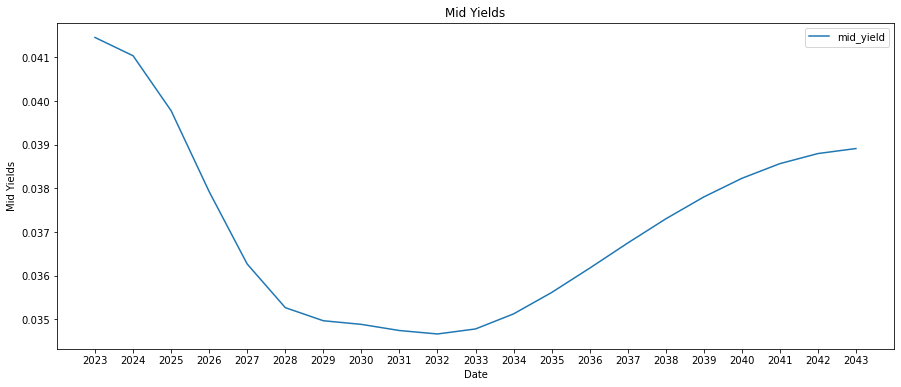

In [23]:
_ = plot_yield_curve(ts_yc_bid,ts_yc_ask,ts_yc_mid, ql.Date(14, 4, 2023), ql.Date(14, 4, 2043), ql.ActualActual(ql.ActualActual.ISMA), 'US Treasury')

>The above yield curves makes sense based on the bloomberg data shown in class (Note we dont have short end tenors and out lond end is only out to 20 years)
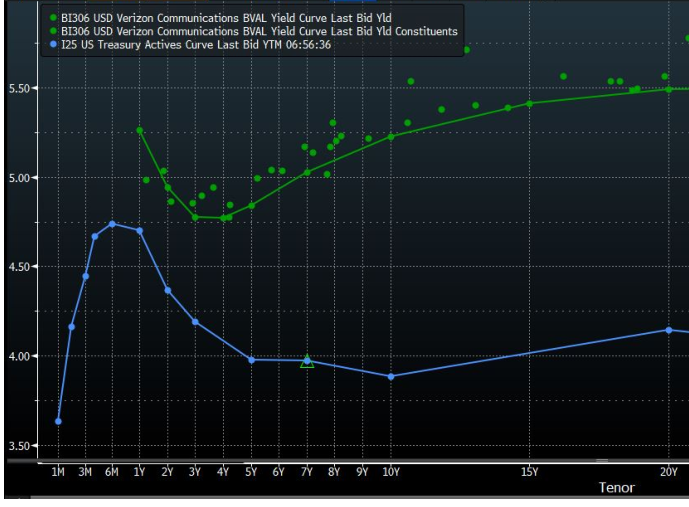

## d. Plot calibrated discount factors

Plot the discount factor curve up to the 30 years point, using a 6 months discretization grid.

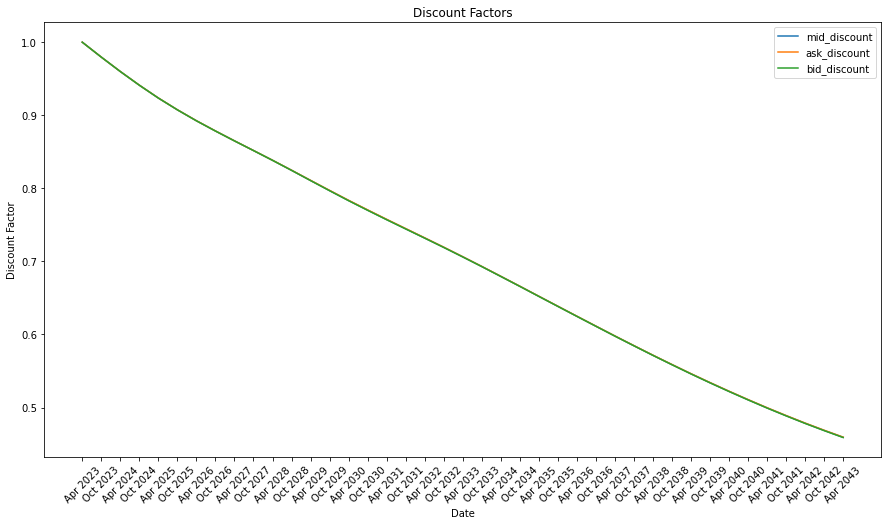

In [24]:
df_calib = plot_yield_curve(ts_yc_bid,ts_yc_ask,ts_yc_mid, ql.Date(14, 4, 2023), ql.Date(14, 4, 2043), ql.ActualActual(ql.ActualActual.ISMA), 'US Treasury', CurveType="discount_6m")

# Problem 3: Pricing and risk metrics for US Treasury bonds

## a. US Treasury pricing on the calibrated discount factor curve

Follow Section 5. "Present Value Calculation (no credit risk)" in the QuantLib introductory notebook to re-price the US on-the-run treasuries using the calibrated discount factor curve. 

You will need to switch the bond_engine to use the new on-the-run treasury yield curve:
bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)

Extend the dataframe with the following computed columns for clean mid prices:


| calc_mid |
|---------------|


To validate the calibration, compare the calculated clean mid prices to the original market mid prices.

In [25]:
treasury_yield_curve_mid_handle = ql.YieldTermStructureHandle(ts_yc_mid)
bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)

In [26]:
symbology_md_otr.head(2)

,ticker,figi,security,name,coupon,days_settle,start_date,acc_first,maturity,term,...,class,ticker_y,isin,bid,ask,mid,mid_dirty,bid_yield,ask_yield,mid_yield
0,T,BBG01DVKBH56,T 3 5/8 02/15/53,US TREASURY N/B,3.625,1,2023-02-15,2023-02-15,2053-02-15,30.00,...,Govt,T,US912810TN81,97.9531,98.0313,97.9922,98.6035,3.739,3.735,3.737
1,T,BBG01F6N6GN1,T 3 7/8 02/15/43,US TREASURY N/B,3.875,1,2023-02-28,2023-02-15,2043-02-15,19.96,...,Govt,T,US912810TQ13,100.2969,100.3750,100.3359,100.9883,3.853,3.847,3.850


In [27]:
#Create a function to price each OTR treasruy using the above bond engine. Extend the datafram with a column 'calc_mid' with the calculated mid price
def price_bond(symbology_df: pd.DataFrame, bond_engine: ql.DiscountingBondEngine, calc_date: ql.Date):
    
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = symbology_df.copy()  
    
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        bond_object.setPricingEngine(bond_engine)
        pv_engine = bond_object.NPV()
        
        sorted_details_frame.loc[index, 'calc_mid'] = pv_engine
        
    return sorted_details_frame

> Compare the calculated clean mid prices to the original market mid prices

In [28]:
symbology_md_otr_calib = price_bond(symbology_md_otr, bond_engine, ql.Date(14, 4, 2023))
symbology_md_otr_calib[['security','TTM','mid','calc_mid']]

,security,TTM,mid,calc_mid
0,T 3 5/8 02/15/53,29.842574,97.9922,98.569540
1,T 3 7/8 02/15/43,19.841205,100.3359,100.954557
2,T 3 1/2 02/15/33,9.842574,99.8672,100.422847
3,T 3 5/8 03/31/30,6.962355,100.4063,100.540502
4,T 3 5/8 03/31/28,4.963723,100.0781,100.212414
5,T 3 7/8 03/31/25,1.963039,99.5762,99.722292
6,T 3 3/4 04/15/26,3.003422,99.7656,99.752188


## b. Compute analytical DV01, Duration and Convexity for US on-the-run treasuries (using flat yield)

Compute analytical DV01, Duration and Convexity metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration. 

Extend the dataframe with the following calculated risk metrics:


| dv01 | duration | convexity |
|-------|-------|-------------|


In [29]:
def calc_bond_metrics(symbology_df: pd.DataFrame, calc_date: ql.Date, model="flat", coupon_freq=ql.Semiannual, yc=None):
    
    ql.Settings.instance().evaluationDate = calc_date
    
    sorted_details_frame = symbology_df.copy()
    flat_rate = ql.SimpleQuote(0.05)
    compounding = ql.Compounded 
    
    for index, row in sorted_details_frame.iterrows():
        fixed_rate_bond = create_bond_from_symbology(row)
        if model == "flat":
            flat_int_rate = ql.InterestRate(flat_rate.value(), fixed_rate_bond.dayCounter(), compounding, coupon_freq)
            bond_duration = ql.BondFunctions.duration(fixed_rate_bond, flat_int_rate)
            bond_convexity = ql.BondFunctions.convexity(fixed_rate_bond, flat_int_rate)
            dv01 = row['mid_dirty'] * bond_duration
            sorted_details_frame.loc[index, 'dv01'] = dv01/100
            sorted_details_frame.loc[index, 'duration'] = bond_duration/100
            sorted_details_frame.loc[index, 'convexity'] = bond_convexity
        elif model == "yc":
            interest_rate_bump = ql.SimpleQuote(0.0)
            flat_yield_curve_bumped = ql.ZeroSpreadedTermStructure(yc, ql.QuoteHandle(interest_rate_bump))
            bond_engine = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(flat_yield_curve_bumped))
            fixed_rate_bond.setPricingEngine(bond_engine)
            price_base = fixed_rate_bond.NPV()
            #-1 bp change in yield
            interest_rate_bump.setValue(-0.0001)
            price_base_1bp = fixed_rate_bond.NPV()
            dv01 = (price_base_1bp - price_base) * 100
            bond_duration = dv01 / row['mid_dirty']
            interest_rate_bump.setValue(0.0001)
            price_base_1bp_u = fixed_rate_bond.NPV()
            bond_convexity = (price_base_1bp_u + price_base_1bp - 2 * price_base) * 1000000 / row['mid_dirty'] *100
            sorted_details_frame.loc[index, 'scen_dv01'] = dv01
            sorted_details_frame.loc[index, 'scen_duration'] = bond_duration
            sorted_details_frame.loc[index, 'scen_convexity'] = bond_convexity
        else:
            print("Please enter a valid model")

    return sorted_details_frame
            
        

In [30]:
symbology_md_otr_calib1 = calc_bond_metrics(symbology_md_otr_calib, ql.Date(14, 4, 2023), model="flat", coupon_freq=ql.Semiannual)

In [31]:
symbology_md_otr_calib1[['security','TTM','dv01','duration','convexity']]

,security,TTM,dv01,duration,convexity
0,T 3 5/8 02/15/53,29.842574,16.157490,0.163863,387.768447
1,T 3 7/8 02/15/43,19.841205,13.195321,0.130662,224.427402
2,T 3 1/2 02/15/33,9.842574,8.073575,0.080368,76.334006
3,T 3 5/8 03/31/30,6.962355,6.042850,0.060084,41.925992
4,T 3 5/8 03/31/28,4.963723,4.456410,0.044455,22.999615
5,T 3 7/8 03/31/25,1.963039,1.845781,0.018503,4.386755
6,T 3 3/4 04/15/26,3.003422,2.781316,0.027873,9.353226


## c. Compute scenario DV01, Duration and Convexity for US on-the-run treasuries (using calibrated yield curve)

Compute the scenario DV01, Duration and Convexity metrics using +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration.

Extend the dataframe with the following scenario sensitivities metrics:

| scen_dv01 | scen_duration | scen_convexity |
|-------|-------|-------------|



In [32]:
symbology_md_otr_calib2 = calc_bond_metrics(symbology_md_otr_calib1, ql.Date(14, 4, 2023), model="yc", coupon_freq=ql.Semiannual, yc=treasury_yield_curve_mid_handle)

In [33]:
symbology_md_otr_calib2[['security','TTM','dv01','scen_dv01','duration','scen_duration','convexity','scen_convexity']]

,security,TTM,dv01,scen_dv01,duration,scen_duration,convexity,scen_convexity
0,T 3 5/8 02/15/53,29.842574,16.157490,17.970860,0.163863,0.182254,387.768447,446.822403
1,T 3 7/8 02/15/43,19.841205,13.195321,14.012389,0.130662,0.138753,224.427402,239.626012
2,T 3 1/2 02/15/33,9.842574,8.073575,8.401851,0.080368,0.083636,76.334006,77.559673
3,T 3 5/8 03/31/30,6.962355,6.042850,6.287876,0.060084,0.062520,41.925992,41.943021
4,T 3 5/8 03/31/28,4.963723,4.456410,4.631607,0.044455,0.046202,22.999615,22.416864
5,T 3 7/8 03/31/25,1.963039,1.845781,1.938457,0.018503,0.019432,4.386755,3.839399
6,T 3 3/4 04/15/26,3.003422,2.781316,2.858789,0.027873,0.028649,9.353226,8.438682


> We see that the duration and convexity are very close to the analytical values

# Problem 4: Pricing and risk metrics for corporate bonds

## a. Create the on-the-run corporate bond objects

Restrict the symbology dataframe to fixed rate corporate bonds only and create the corporate bond objects.

In [34]:
symbology_md_corp = symbology_md[symbology_md['ticker']!="T"]
symbology_md_corp.reset_index(inplace=True, drop=True)

> Creating corporate bond objects

In [35]:
#create a corp bond obj dictionary with key as the figi and value as the bond object
corp_bond_objs = {}
for i in range(symbology_md_corp.shape[0]):
    corp_bond_objs[symbology_md_corp.iloc[i]['figi']] = create_bond_from_symbology(symbology_md_corp.iloc[i])

>Showing that the objects have been created

In [36]:
#show first 2 bond objects
list(corp_bond_objs.values())[0:2]

[<QuantLib.QuantLib.FixedRateBond; proxy of <Swig Object of type 'ext::shared_ptr< FixedRateBond > *' at 0x00000210520BB600> >,
 <QuantLib.QuantLib.FixedRateBond; proxy of <Swig Object of type 'ext::shared_ptr< FixedRateBond > *' at 0x00000210521587E0> >]

## b. Compute analytical Yields and Z-Spreads

Compute analytical Yields and Z-Spreads metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_yield | calc_zspread |
|-------|-------------|


In [37]:
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

# using 5% flat interest rate for testing
flat_rate = ql.SimpleQuote(0.05)
rate_handle = ql.QuoteHandle(flat_rate)
day_count = ql.Actual360()
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
continuous_comp = ql.Continuous # continously compounded rate of 5%
flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)
flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)

In [38]:
#add he calc_yield and calc_zspread columns to the symbology_md_corp dataframe for each bond
for i in range(symbology_md_corp.shape[0]):
    temp_bond = corp_bond_objs[symbology_md_corp.iloc[i]['figi']]
    symbology_md_corp.loc[i, 'calc_yield'] = temp_bond.bondYield(symbology_md_corp.iloc[i]['mid'], temp_bond.dayCounter(), ql.Compounded, ql.Semiannual, temp_bond.settlementDate(calc_date)) * 100
    bond_market_price = symbology_md_corp.iloc[i]['mid']
    symbology_md_corp.loc[i, 'calc_zspread'] = ql.BondFunctions.zSpread(temp_bond, bond_market_price, flat_yield_curve, temp_bond.dayCounter(), ql.Compounded, ql.Semiannual, temp_bond.settlementDate(calc_date))

In [39]:
symbology_md_corp[['security','TTM','mid_yield','calc_yield','calc_zspread']]

,security,TTM,mid_yield,calc_yield,calc_zspread
0,DIS 3.7 09/15/24,1.423682,4.6150,4.614951,-0.005294
1,DIS 3.7 10/15/25,2.505133,4.2820,4.282420,-0.008472
2,DIS 3 3/8 11/15/26,3.589322,4.2170,4.217140,-0.009111
3,DIS 6.55 03/15/33,9.919233,4.5765,4.576648,-0.005533
4,DIS 6.2 12/15/34,11.671458,4.7080,4.707955,-0.004247
...,...,...,...,...,...
214,VZ 4.15 05/15/29,6.086242,4.9610,4.960332,-0.001754
215,VZ 4.65 06/15/52,29.171800,5.4800,5.478803,0.003352
216,VZ 4.6 08/15/52,29.338809,5.4410,5.440116,0.002966
217,VZ 4 1/2 09/15/29,6.422998,4.7850,4.784810,-0.003505


## c. Validate Z-Spread computation for a few fixed rate corporate bonds

Pick 3 corporate bonds (at your discretion) and use function below to re-price them using the calibrated flat z-spread. Follow the example in Section 9. "Duration, Convexity and Z-Spread (flat yield model)".

Validate that you match the original market price, which were used as input to the z-Spread function.


In [40]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price

>We used mid clean prices for the z-spread calculations

In [41]:
#select three random bonds from the symbology_md_corp dataframe and apply the calc_clean_price_with_zspread function
for i in range(3):
    rand_index = random.randint(0, symbology_md_corp.shape[0])
    bond = corp_bond_objs[symbology_md_corp.iloc[rand_index]['figi']]
    bond_market_price = symbology_md_corp.iloc[rand_index]['mid']
    bond_zspread = symbology_md_corp.iloc[rand_index]['calc_zspread']
    bond_zspread_clean_price = calc_clean_price_with_zspread(bond, flat_yield_curve_handle, bond_zspread)
    print("Bond: ", symbology_md_corp.iloc[rand_index]['security'])
    print("ZSpread bps: ", round(bond_zspread * 10000,2))
    print("Market Price: ", bond_market_price)
    print("ZSpread Clean Price: ", bond_zspread_clean_price)
    print("Difference: ", bond_market_price - bond_zspread_clean_price)
    print("----------------------------------")

Bond:  DIS 2 3/4 09/01/49
ZSpread bps:  -31.67
Market Price:  69.314
ZSpread Clean Price:  69.31399997296198
Difference:  2.7038012717639504e-08
----------------------------------
Bond:  ORCL 5.8 11/10/25
ZSpread bps:  -44.9
Market Price:  102.646
ZSpread Clean Price:  102.64599999999999
Difference:  1.4210854715202004e-14
----------------------------------
Bond:  ORCL 5 3/8 07/15/40
ZSpread bps:  60.11
Market Price:  95.935
ZSpread Clean Price:  95.93500000051388
Difference:  -5.138787173564197e-10
----------------------------------


## d. Compute Duration and Convexity for fixed rate corporate bonds (using flat yield)

Compute analytical Duration and Convexity metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_duration | calc_convexity |
|-------|-------------|


In [42]:
symbology_md_corp_calib1 = calc_bond_metrics(symbology_md_corp, ql.Date(14, 4, 2023), model="flat", coupon_freq=ql.Semiannual)

In [43]:
symbology_md_corp_calib1[['security','TTM','dv01','duration','convexity']]

,security,TTM,dv01,duration,convexity
0,DIS 3.7 09/15/24,1.423682,1.335191,0.013473,2.493466
1,DIS 3.7 10/15/25,2.505133,2.311098,0.023423,6.751805
2,DIS 3 3/8 11/15/26,3.589322,3.216770,0.032603,12.731333
3,DIS 6.55 03/15/33,9.919233,8.566744,0.073741,67.816971
4,DIS 6.2 12/15/34,11.671458,9.550981,0.082778,87.729796
...,...,...,...,...,...
214,VZ 4.15 05/15/29,6.086242,5.060078,0.051869,31.969098
215,VZ 4.65 06/15/52,29.171800,13.651517,0.152390,343.563214
216,VZ 4.6 08/15/52,29.338809,13.670068,0.154368,349.916013
217,VZ 4 1/2 09/15/29,6.422998,5.402809,0.054656,35.196260
